In [1]:
import sys
sys.path.append('../../../')

In [2]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed, ConfusionMatrix
from sklearn.metrics import matthews_corrcoef, mean_squared_error

c:\Users\vibal\miniconda3\envs\ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [4]:
do_train = True

seed = 4444
set_seed(seed)

metric_filter_1 = 'val_mcc'
metric_filter_2 = 'test_mcc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [5]:
sets_lengths = (0.6, 0.15, 0.25)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = dataset.num_classes

In [6]:
(dataset[0].ndata['train_mask']).sum()

tensor(866)

In [7]:
(dataset[0].ndata['val_mask']).sum()

tensor(216)

In [8]:
(dataset[0].ndata['test_mask']).sum()

tensor(362)

## Baseline

In [9]:
dict_small_acc_train = {}
dict_small_acc_val = {}
dict_small_acc_test = {}
dict_small_rmse_train = {}
dict_small_rmse_val = {}
dict_small_rmse_test = {}
dict_small_mcc_train = {}
dict_small_mcc_val = {}
dict_small_mcc_test = {}

In [10]:
# x_train,x_test,y_train,y_test = train_test_split(dataset.node_features[0].to_numpy(), dataset.targets[0], test_size=0.25, random_state=seed)
g_data = dataset.graphs[0].ndata
feats = g_data['feat']
labels = g_data['label']
train_mask = g_data['train_mask']
val_mask = g_data['val_mask']
test_mask = g_data['test_mask']

# train + val for training, test for test
x_train,x_test = feats[torch.logical_not(test_mask)], feats[test_mask]
y_train,y_test = labels[torch.logical_not(test_mask)], labels[test_mask]

In [11]:
x_train.shape

torch.Size([1082, 4])

In [12]:
x_test.shape

torch.Size([362, 4])

### Logistic Regression

In [13]:
model_lr = LogisticRegression(multi_class='multinomial',random_state=seed, max_iter=800).fit(x_train, y_train)
print(classification_report(y_true=y_test, y_pred=model_lr.predict(x_test)))

              precision    recall  f1-score   support

           0       0.38      0.80      0.52        87
           1       0.33      0.01      0.02        91
           2       0.45      0.61      0.52        97
           3       0.89      0.47      0.62        87

    accuracy                           0.47       362
   macro avg       0.51      0.47      0.42       362
weighted avg       0.51      0.47      0.42       362



In [14]:
dict_small_acc_train['logistic_regression'] = model_lr.score(x_train, y_train)
dict_small_acc_test['logistic_regression'] = model_lr.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['logistic_regression']}")
print(f"Test accuracy: {dict_small_acc_test['logistic_regression']}")

dict_small_rmse_train['logistic_regression'] = mean_squared_error(y_true=y_train,y_pred=model_lr.predict(x_train), squared=False)
dict_small_rmse_test['logistic_regression'] = mean_squared_error(y_true=y_test,y_pred=model_lr.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['logistic_regression']}")
print(f"Test rmse: {dict_small_rmse_test['logistic_regression']}")

dict_small_mcc_train['logistic_regression'] = matthews_corrcoef(y_true=y_train,y_pred=model_lr.predict(x_train))
dict_small_mcc_test['logistic_regression'] = matthews_corrcoef(y_true=y_test,y_pred=model_lr.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['logistic_regression']}")
print(f"Test mcc: {dict_small_mcc_test['logistic_regression']}")

Train accuracy: 0.48151571164510165
Test accuracy: 0.4723756906077348
Train rmse: 1.2303914890254133
Test rmse: 1.2224872752391114
Train mcc: 0.3486354823922108
Test mcc: 0.330969286936101


### Random Forest

In [15]:
# # x_train_rf,x_val_rf,y_train_rf,y_val_rf = train_test_split(x_train, y_train, test_size=0.2, random_state=seed)
# x_train_rf,x_val_rf,x_test_rf = feats[train_mask], feats[val_mask], feats[test_mask]
# y_train_rf,y_val_rf,y_test_rf = labels[train_mask], labels[val_mask], labels[test_mask]
x_train_rf = x_train
y_train_rf = y_train
x_val_rf = x_test
y_val_rf = y_test

In [16]:
n = 20
num_nodes = x_train_rf.shape[0]
model_rf = None
val_acc = 0.0
for k in trange(1,num_nodes, (num_nodes - 1) // n):
    tmp = RandomForestClassifier(random_state=seed, n_estimators=k).fit(x_train_rf,y_train_rf)
    tmp_acc = matthews_corrcoef(y_true=y_val_rf,y_pred=tmp.predict(x_val_rf))
    if val_acc < tmp_acc:
        val_acc = tmp_acc
        model_rf = tmp

print(classification_report(y_true=y_test, y_pred=model_rf.predict(x_test)))

100%|██████████| 21/21 [00:33<00:00,  1.61s/it]

              precision    recall  f1-score   support

           0       0.58      0.56      0.57        87
           1       0.53      0.51      0.52        91
           2       0.67      0.62      0.65        97
           3       0.78      0.92      0.84        87

    accuracy                           0.65       362
   macro avg       0.64      0.65      0.65       362
weighted avg       0.64      0.65      0.64       362



In [17]:
model_rf

RandomForestClassifier(n_estimators=325, random_state=4444)

In [18]:
dict_small_acc_train['random_forest'] = model_rf.score(x_train_rf, y_train_rf)
dict_small_acc_val['random_forest'] = model_rf.score(x_val_rf, y_val_rf)
dict_small_acc_test['random_forest'] = model_rf.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['random_forest']}")
print(f"Val accuracy: {dict_small_acc_val['random_forest']}")
print(f"Test accuracy: {dict_small_acc_test['random_forest']}")

dict_small_rmse_train['random_forest'] = mean_squared_error(y_true=y_train_rf,y_pred=model_rf.predict(x_train_rf), squared=False)
dict_small_rmse_val['random_forest'] = mean_squared_error(y_true=y_val_rf,y_pred=model_rf.predict(x_val_rf), squared=False)
dict_small_rmse_test['random_forest'] = mean_squared_error(y_true=y_test,y_pred=model_rf.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['random_forest']}")
print(f"Val rmse: {dict_small_rmse_val['random_forest']}")
print(f"Test rmse: {dict_small_rmse_test['random_forest']}")

dict_small_mcc_train['random_forest'] = matthews_corrcoef(y_true=y_train_rf,y_pred=model_rf.predict(x_train_rf))
dict_small_mcc_val['random_forest'] = matthews_corrcoef(y_true=y_val_rf,y_pred=model_rf.predict(x_val_rf))
dict_small_mcc_test['random_forest'] = matthews_corrcoef(y_true=y_test,y_pred=model_rf.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['random_forest']}")
print(f"Val mcc: {dict_small_mcc_val['random_forest']}")
print(f"Test mcc: {dict_small_mcc_test['random_forest']}")

Train accuracy: 0.9990757855822551
Val accuracy: 0.649171270718232
Test accuracy: 0.649171270718232
Train rmse: 0.03040089501552408
Val rmse: 0.9387307758954426
Test rmse: 0.9387307758954426
Train mcc: 0.998768763267822
Val mcc: 0.5333457250518097
Test mcc: 0.5333457250518097


In [19]:
cm_rf = ConfusionMatrix(size=4)
cm_rf.add(preds=torch.as_tensor(model_rf.predict(x_test)), labels=torch.as_tensor(y_test))

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

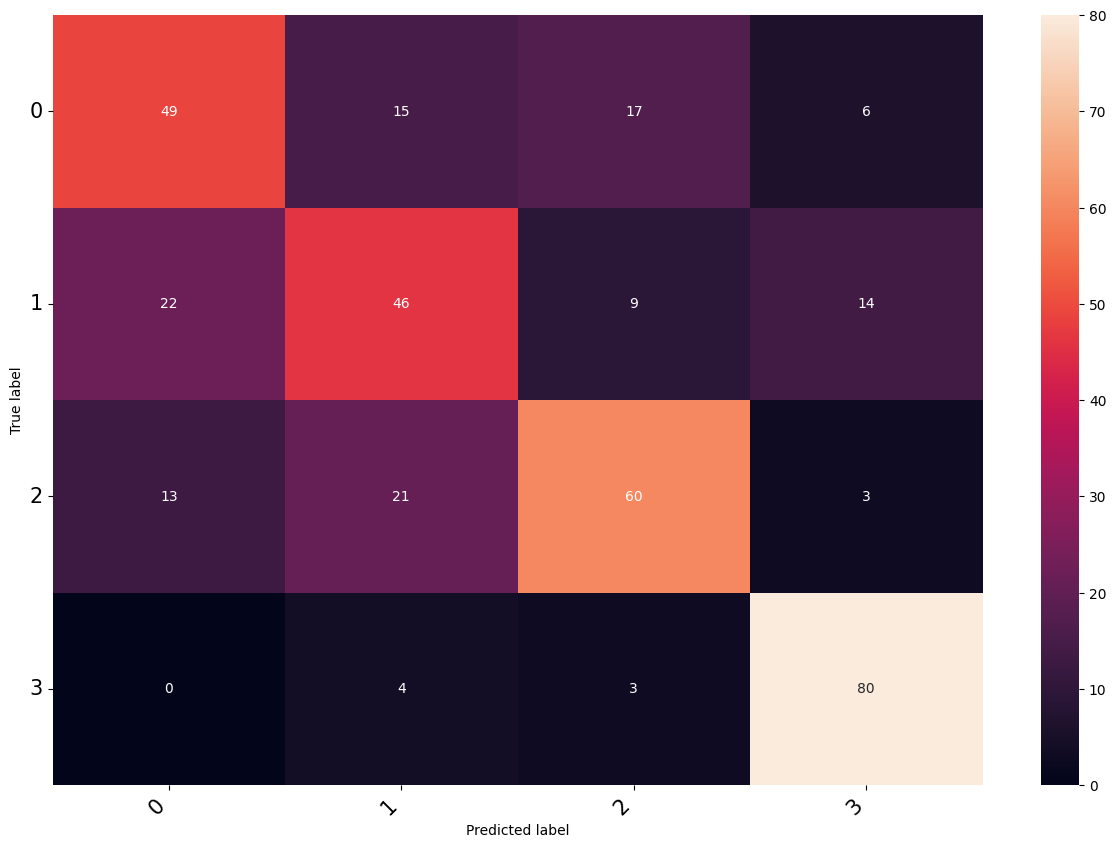

In [20]:
cm_rf.visualize()

In [21]:
cm_rf.class_accuracy

tensor([0.5632, 0.5055, 0.6186, 0.9195])

In [22]:
(cm_rf.labels==0).sum()

tensor(87)

### KNN Classifier

In [23]:
model_knn = KNeighborsClassifier(n_neighbors=out_feats).fit(x_train,y_train)
print(classification_report(y_true=y_test, y_pred=model_knn.predict(x_test)))

              precision    recall  f1-score   support

           0       0.46      0.57      0.51        87
           1       0.45      0.44      0.44        91
           2       0.61      0.40      0.48        97
           3       0.63      0.74      0.68        87

    accuracy                           0.53       362
   macro avg       0.54      0.54      0.53       362
weighted avg       0.54      0.53      0.53       362



In [24]:
dict_small_acc_train['knn_classifier'] = model_knn.score(x_train_rf, y_train_rf)
dict_small_acc_test['knn_classifier'] = model_knn.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['knn_classifier']}")
print(f"Test accuracy: {dict_small_acc_test['knn_classifier']}")

dict_small_rmse_train['knn_classifier'] = mean_squared_error(y_true=y_train_rf,y_pred=model_knn.predict(x_train_rf), squared=False)
dict_small_rmse_test['knn_classifier'] = mean_squared_error(y_true=y_test,y_pred=model_knn.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['knn_classifier']}")
print(f"Test rmse: {dict_small_rmse_test['knn_classifier']}")

dict_small_mcc_train['knn_classifier'] = matthews_corrcoef(y_true=y_train_rf,y_pred=model_knn.predict(x_train_rf))
dict_small_mcc_test['knn_classifier'] = matthews_corrcoef(y_true=y_test,y_pred=model_knn.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['knn_classifier']}")
print(f"Test mcc: {dict_small_mcc_test['knn_classifier']}")

Train accuracy: 0.7079482439926063
Test accuracy: 0.5331491712707183
Train rmse: 0.8946338277569756
Test rmse: 1.1752512368056711
Train mcc: 0.6132928827645755
Test mcc: 0.3826074980693433


### FNN

In [25]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[100], [100] * 2, [100] * 3, [200], [200]*2,[200]*3,[500],[500]*2,[500]*3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    label_smoothing=[0.0, 0.2],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [26]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=False,
            scheduler_patience=20,
        )

100%|██████████| 108/108 [06:15<00:00,  3.48s/it]


#### Results

In [27]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 1971/1971 [01:03<00:00, 30.91it/s]


In [28]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [100, 100, 100],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': False,
 'tr_par_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.4513839031259494,
 'epoch': 100,
 'train_loss': 0.73169124,
 'train_acc': 0.6651270389556885,
 'val_acc': 0.5694444179534912,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.57_2023-03-30_03.38.13.055696_100',
 'train_rmse': 0.8488546828034355,
 'val_rmse': 0.9403506044339309,
 'test_rmse': 0.9748211338978667,
 'train_mae': 0.45958429561200925,
 'val_mae': 0.5787037037037037,
 'test_mae': 0.569060773480663,
 'train_mcc': 0.5597847291392147,
 'test_mcc': 0.489225899112771,
 'test_acc': 0.610497236251831,
 'train_rmse_perc': 0.21718664,
 'val_rmse_perc': 0.23731522,
 'test_rmse_perc': 0.24836509,
 't

In [29]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [100, 100, 100],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': False,
 'tr_par_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.5424476425843968,
 'epoch': 55,
 'train_loss': 0.8101243,
 'train_acc': 0.6258660554885864,
 'val_acc': 0.6620370149612427,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.66_2023-03-30_03.38.13.055696',
 'train_rmse': 0.8696844480965323,
 'val_rmse': 0.9128709291752769,
 'test_rmse': 1.0123546208977559,
 'train_mae': 0.5,
 'val_mae': 0.5,
 'test_mae': 0.6160220994475138,
 'train_mcc': 0.513057051833296,
 'test_mcc': 0.4512443899163025,
 'test_acc': 0.580110490322113,
 'train_rmse_perc': 0.22624879,
 'val_rmse_perc': 0.24400024,
 'test_rmse_perc': 0.25871575,
 'train_mae_perc': 0.16144341,
 'val_ma

In [30]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [100, 100, 100],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': False,
 'tr_par_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.4513839031259494,
 'epoch': 100,
 'train_loss': 0.73169124,
 'train_acc': 0.6651270389556885,
 'val_acc': 0.5694444179534912,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.57_2023-03-30_03.38.13.055696_100',
 'train_rmse': 0.8488546828034355,
 'val_rmse': 0.9403506044339309,
 'test_rmse': 0.9748211338978667,
 'train_mae': 0.45958429561200925,
 'val_mae': 0.5787037037037037,
 'test_mae': 0.569060773480663,
 'train_mcc': 0.5597847291392147,
 'test_mcc': 0.489225899112771,
 'test_acc': 0.610497236251831,
 'train_rmse_perc': 0.21718664,
 'val_rmse_perc': 0.23731522,
 'test_rmse_perc': 0.24836509,
 't

In [31]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1971/1971 [00:00<00:00, 26810.44it/s]


### Baseline Overall

In [32]:
print(dict_small_acc_train)
print(dict_small_acc_val)
print(dict_small_acc_test)

{'logistic_regression': 0.48151571164510165, 'random_forest': 0.9990757855822551, 'knn_classifier': 0.7079482439926063}
{'random_forest': 0.649171270718232}
{'logistic_regression': 0.4723756906077348, 'random_forest': 0.649171270718232, 'knn_classifier': 0.5331491712707183}


In [33]:
print(dict_small_mcc_train)
print(dict_small_mcc_val)
print(dict_small_mcc_test)

{'logistic_regression': 0.3486354823922108, 'random_forest': 0.998768763267822, 'knn_classifier': 0.6132928827645755}
{'random_forest': 0.5333457250518097}
{'logistic_regression': 0.330969286936101, 'random_forest': 0.5333457250518097, 'knn_classifier': 0.3826074980693433}


In [34]:
print(dict_small_rmse_train)
print(dict_small_rmse_val)
print(dict_small_rmse_test)

{'logistic_regression': 1.2303914890254133, 'random_forest': 0.03040089501552408, 'knn_classifier': 0.8946338277569756}
{'random_forest': 0.9387307758954426}
{'logistic_regression': 1.2224872752391114, 'random_forest': 0.9387307758954426, 'knn_classifier': 1.1752512368056711}


### GCN

In [35]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [36]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

100%|██████████| 144/144 [14:40<00:00,  6.12s/it]


#### Results

In [37]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 1831/1831 [01:19<00:00, 23.15it/s]


In [38]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.23255971595136954,
 'epoch': 90,
 'train_loss': 1179.6497,
 'train_acc': 0.4122401773929596,
 'val_acc': 0.3842592239379883,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.38_2023-03-30_03.45.00.157072_90',
 'train_rmse': 1.3378483984302736,
 'val_rmse': 1.415849437486073,
 'test_rmse': 1.3502608710502955,
 'train_mae': 0.9422632794457275,
 'val_mae': 1.0324074074074074,
 'test_mae': 0.9502762430939227,
 'train_mcc': 0.2587692892947702,
 'test_mcc': 0.2504475037359199,
 'test_acc': 0.41436463594436646,
 'train_rmse_perc': 0.33009946,
 'val_rmse_perc': 0.34970093,
 'test_rmse_pe

In [39]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.3459906220257893,
 'epoch': 80,
 'train_loss': 1128.1711,
 'train_acc': 0.41454964876174927,
 'val_acc': 0.4999999701976776,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.50_2023-03-30_03.45.00.157072_80',
 'train_rmse': 1.4667209031892174,
 'val_rmse': 1.4027090192169553,
 'test_rmse': 1.496773694221243,
 'train_mae': 1.0242494226327945,
 'val_mae': 0.9027777777777778,
 'test_mae': 1.0635359116022098,
 'train_mcc': 0.2743416759967773,
 'test_mcc': 0.24693934465854378,
 'test_acc': 0.4005524814128876,
 'train_rmse_perc': 0.36251026,
 'val_rmse_perc': 0.35276553,
 'test_rmse_pe

In [40]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.33882035046858117,
 'epoch': 79,
 'train_loss': 1274.9868,
 'train_acc': 0.4030023217201233,
 'val_acc': 0.49074071645736694,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.49_2023-03-30_03.45.00.157072',
 'train_rmse': 1.4901524326448354,
 'val_rmse': 1.4449785337377725,
 'test_rmse': 1.5132928495895248,
 'train_mae': 1.0519630484988454,
 'val_mae': 0.9398148148148148,
 'test_mae': 1.080110497237569,
 'train_mcc': 0.26947416750491665,
 'test_mcc': 0.25399067611849874,
 'test_acc': 0.39502763748168945,
 'train_rmse_perc': 0.36766577,
 'val_rmse_perc': 0.36311284,
 'test_rmse_pe

In [41]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1831/1831 [00:00<00:00, 30260.10it/s]


### GraphSAGE

In [42]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
#     out_features = [out_feats],
#     # aggregator_type = ['mean', 'lstm'],
#     aggregator_type = ['lstm'],
#     norm_edges = ['right', 'none'],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0.2, 0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0, 0.2],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0,0.2],
# )
# list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[500]*2], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['none'],
    norm_nodes = ['gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0, 0.2],
    # other
    lr=[1e-2],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0, 0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [43]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=2000,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=50,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
            scheduler_patience=300,
        )

100%|██████████| 8/8 [2:57:05<00:00, 1328.21s/it]  


#### Results

In [44]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 422/422 [01:55<00:00,  3.66it/s]


In [45]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.6901783083446161,
 'epoch': 1150,
 'train_loss': 0.7693181,
 'train_acc': 0.931870698928833,
 'val_acc': 0.7685184478759766,
 'model_class': 'sage',
 'path_name': 'saved_sage\\0.77_2023-03-30_05.09.43.025915_1150',
 'train_rmse': 0.38295074122901523,
 'val_rmse': 0.7359800721939872,
 'test_rmse': 0.8491139353102866,
 'train_mae': 0.09122401847575058,
 'val_mae': 0.3287037037037037,
 'test_mae': 0.4171270718232044,
 'train_mcc': 0.9096471599980032,
 'test_mcc': 0.6287611131042548,
 'test_acc': 0.7209944725036621,
 'train_rmse_perc': 0.115207665,
 'val_rms

In [46]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.728264529011697,
 'epoch': 292,
 'train_loss': 0.8684145,
 'train_acc': 0.8718245029449463,
 'val_acc': 0.796296238899231,
 'model_class': 'sage',
 'path_name': 'saved_sage\\0.80_2023-03-30_05.09.43.025915',
 'train_rmse': 0.5655629336074542,
 'val_rmse': 0.7576767609436587,
 'test_rmse': 0.9224037777902734,
 'train_mae': 0.18822170900692842,
 'val_mae': 0.3148148148148148,
 'test_mae': 0.5027624309392266,
 'train_mcc': 0.8304187102489817,
 'test_mcc': 0.5462423697105114,
 'test_acc': 0.6574585437774658,
 'train_rmse_perc': 0.15200451,
 'val_rmse_perc': 

In [47]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.6901783083446161,
 'epoch': 1150,
 'train_loss': 0.7693181,
 'train_acc': 0.931870698928833,
 'val_acc': 0.7685184478759766,
 'model_class': 'sage',
 'path_name': 'saved_sage\\0.77_2023-03-30_05.09.43.025915_1150',
 'train_rmse': 0.38295074122901523,
 'val_rmse': 0.7359800721939872,
 'test_rmse': 0.8491139353102866,
 'train_mae': 0.09122401847575058,
 'val_mae': 0.3287037037037037,
 'test_mae': 0.4171270718232044,
 'train_mcc': 0.9096471599980032,
 'test_mcc': 0.6287611131042548,
 'test_acc': 0.7209944725036621,
 'train_rmse_perc': 0.115207665,
 'val_rms

In [48]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 422/422 [00:00<00:00, 29004.92it/s]


#### cm

In [49]:
cm = all[sort_idx[0]]['test_cm'][0]

In [50]:
(cm.labels==0).sum()

tensor(87)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

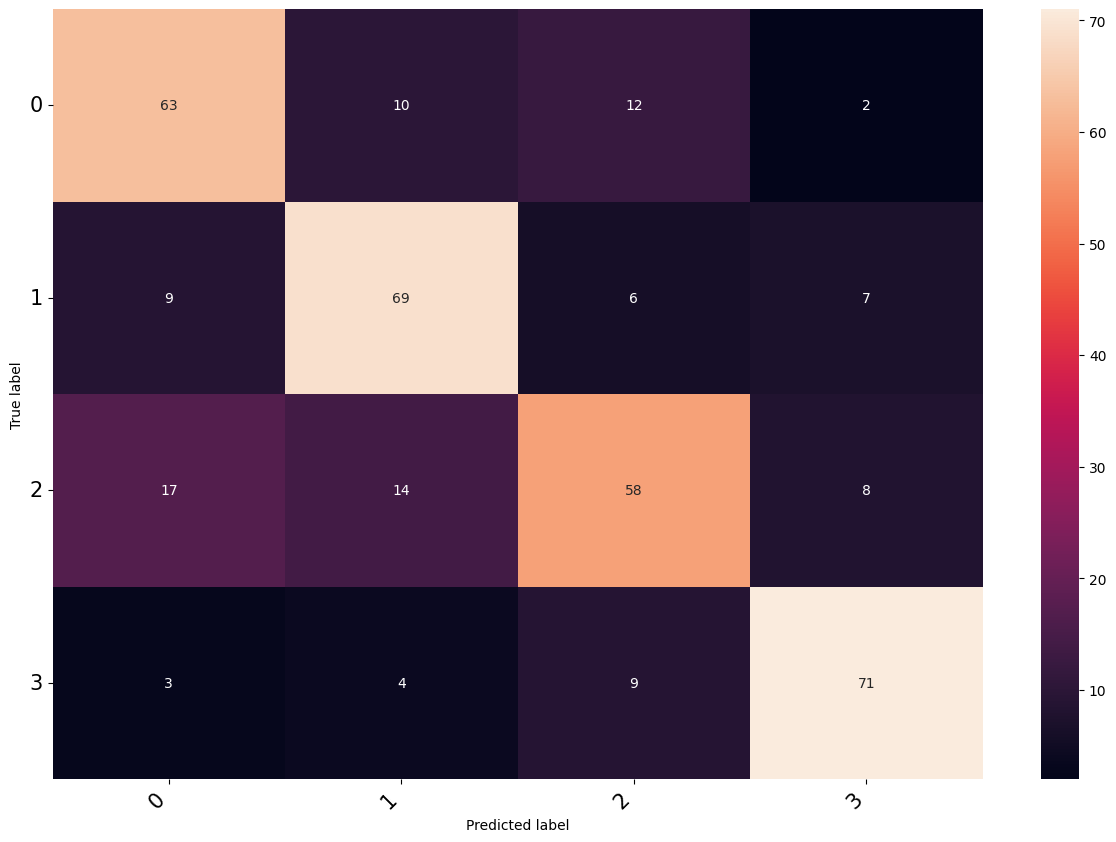

In [51]:
cm.visualize()

In [52]:
cm.class_accuracy

tensor([0.7241, 0.7582, 0.5979, 0.8161])

### GAT

In [53]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [54]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

100%|██████████| 576/576 [50:20<00:00,  5.24s/it]


#### Results

In [55]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 10356/10356 [06:04<00:00, 28.40it/s]


In [56]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [20],
 'out_features': 4,
 'num_heads': [4, 2],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.4434569391703384,
 'epoch': 99,
 'train_loss': 1.1459693,
 'train_acc': 0.550808310508728,
 'val_acc': 0.5694444179534912,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.57_2023-03-30_07.28.03.923604',
 'train_rmse': 1.4203242644432579,
 'val_rmse': 1.4417710302623312,
 'test_rmse': 1.3492375583826135,
 'train_mae': 0.8879907621247113,
 'val_mae': 0.8935185185185185,
 'test_mae': 0.8149171270718232,
 'train_mcc': 0.42449491577482784,
 'test_mcc': 0.4587119429847251,
 'test_acc': 0.5773480534553528,
 'train_rmse_perc': 0.3640

In [57]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20],
 'out_features': 4,
 'num_heads': [4, 4],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.4789940405162281,
 'epoch': 57,
 'train_loss': 1.1804411,
 'train_acc': 0.5646651387214661,
 'val_acc': 0.611111044883728,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.61_2023-03-30_07.24.55.445941',
 'train_rmse': 1.3494503200495211,
 'val_rmse': 1.3960924303476736,
 'test_rmse': 1.36551854032741,
 'train_mae': 0.8233256351039261,
 'val_mae': 0.8101851851851852,
 'test_mae': 0.8591160220994475,
 'train_mcc': 0.43542002539701163,
 'test_mcc': 0.39397208393019023,
 'test_acc': 0.530386745929718,
 'train_rmse_perc': 0.3398

In [58]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20],
 'out_features': 4,
 'num_heads': [4, 2],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.4434569391703384,
 'epoch': 99,
 'train_loss': 1.1459693,
 'train_acc': 0.550808310508728,
 'val_acc': 0.5694444179534912,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.57_2023-03-30_07.28.03.923604',
 'train_rmse': 1.4203242644432579,
 'val_rmse': 1.4417710302623312,
 'test_rmse': 1.3492375583826135,
 'train_mae': 0.8879907621247113,
 'val_mae': 0.8935185185185185,
 'test_mae': 0.8149171270718232,
 'train_mcc': 0.42449491577482784,
 'test_mcc': 0.4587119429847251,
 'test_acc': 0.5773480534553528,
 'train_rmse_perc': 0.3640

In [59]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 10356/10356 [00:00<00:00, 30585.39it/s]
